In this notebook, let's use CNN to classify images from CIFAR-10 database

In [ ]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

# PyTorch dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


ok! time to load the data.

In [ ]:
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# Data transform to convert data to a tensor and apply normalization

# augment train and validation dataset with Flip and Rotation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 47304467.17it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# let's start splitting the data

# obtain training indices that will be usd for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining traing and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare the data loaders(combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
# specify the image classes/labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

let's define a simple helper function which will help in visualization of a bath of trainng data.

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
images, labels = next(iter(train_loader))
images = images.numpy() # convert images to numpy for display
images.shape # batch_size, RGB/BW, width, height

(20, 3, 32, 32)

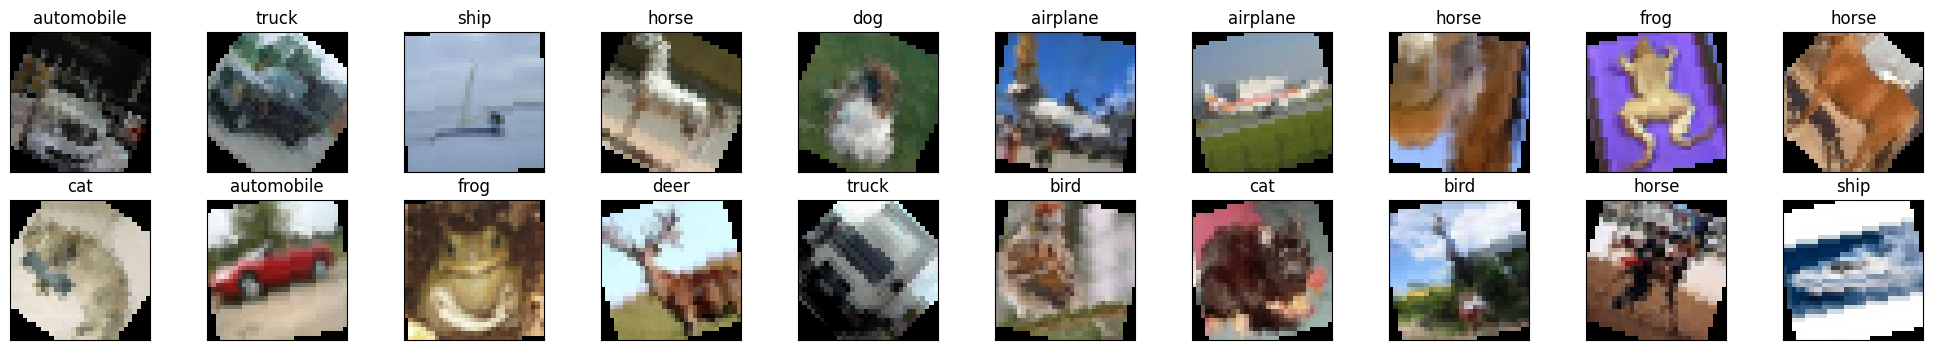

In [ ]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# View an Image in More Detail
Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

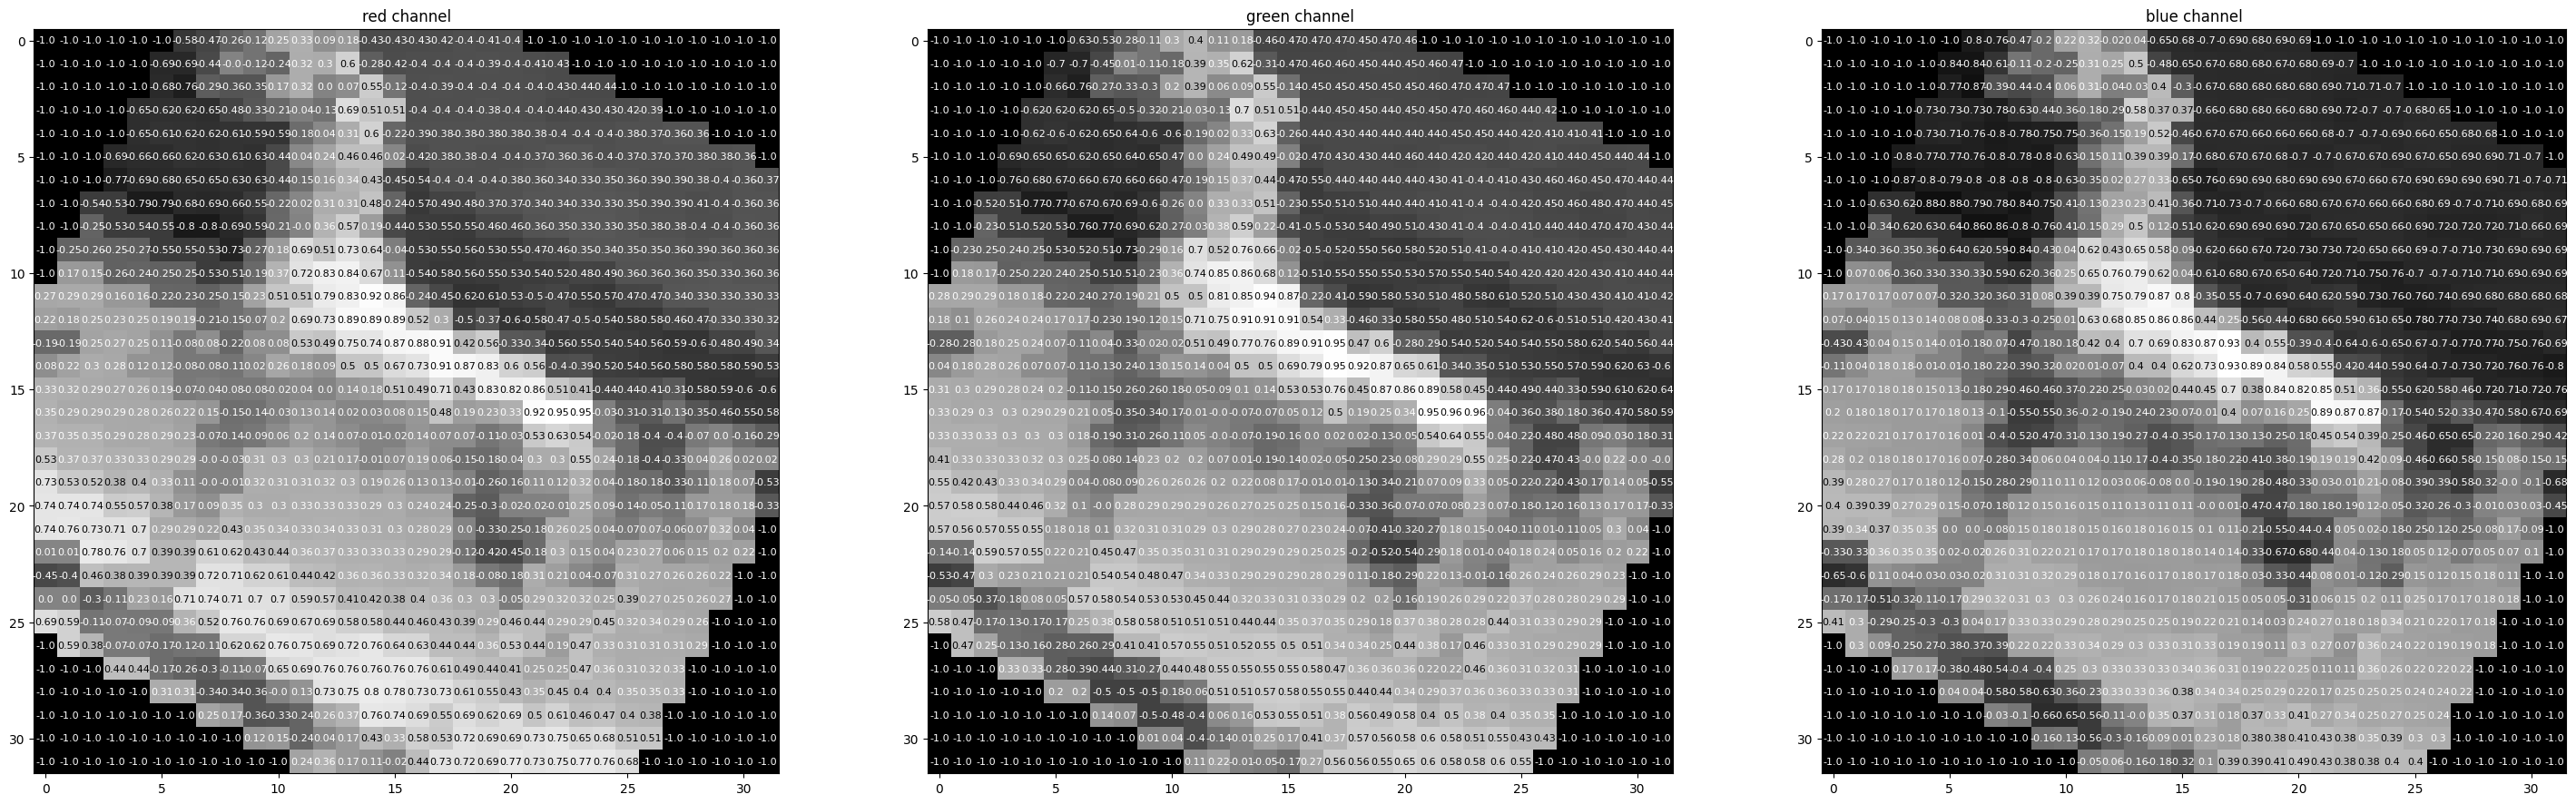

In [ ]:
rgb_img = np.squeeze(images[3]) # horse
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

Now let's defne the network architecture and also train the model.
Define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # let's define convolutional layers
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer o/ps 32x32x16 tensor
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer o/ps 16x16x32 tensor after pooling
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer o/ps 8x8x64 tensor after pooling

        # max pooling layer
        self.pool = nn.MaxPool2d(2,2)

        # linear layer (64 * 8 * 8 -> 1024)
        self.fc1 = nn.Linear(64*8*8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

        # dropout layer (p = 0.25)
        self.dropout = nn.Dropout(0.35)


    def forward(self, x):

        # add sequence of convolutional and max pooling layer
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # flatten image input
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        # add dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x


In [ ]:
# create a complete CNN
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)

In [ ]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

specifying the loss function and optimizer

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# train the network
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.295053 	Validation Loss: 2.242344
Validation loss decreased (inf --> 2.242344).  Saving model ...
Epoch: 2 	Training Loss: 2.085654 	Validation Loss: 1.962147
Validation loss decreased (2.242344 --> 1.962147).  Saving model ...
Epoch: 3 	Training Loss: 1.940000 	Validation Loss: 1.829702
Validation loss decreased (1.962147 --> 1.829702).  Saving model ...
Epoch: 4 	Training Loss: 1.789856 	Validation Loss: 1.662934
Validation loss decreased (1.829702 --> 1.662934).  Saving model ...
Epoch: 5 	Training Loss: 1.659365 	Validation Loss: 1.543481
Validation loss decreased (1.662934 --> 1.543481).  Saving model ...
Epoch: 6 	Training Loss: 1.569148 	Validation Loss: 1.476173
Validation loss decreased (1.543481 --> 1.476173).  Saving model ...
Epoch: 7 	Training Loss: 1.508091 	Validation Loss: 1.410542
Validation loss decreased (1.476173 --> 1.410542).  Saving model ...
Epoch: 8 	Training Loss: 1.449653 	Validation Loss: 1.413327
Epoch: 9 	Training Loss: 1.394691 

Might need to increase the number of epochs to around 50 if we want better accuracy.

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

# Test the Trained Network
Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.765870

Test Accuracy of airplane: 75% (753/1000)
Test Accuracy of automobile: 84% (848/1000)
Test Accuracy of  bird: 62% (624/1000)
Test Accuracy of   cat: 52% (520/1000)
Test Accuracy of  deer: 69% (695/1000)
Test Accuracy of   dog: 70% (700/1000)
Test Accuracy of  frog: 81% (815/1000)
Test Accuracy of horse: 74% (745/1000)
Test Accuracy of  ship: 84% (840/1000)
Test Accuracy of truck: 80% (809/1000)

Test Accuracy (Overall): 73% (7349/10000)


Visualize sample test results

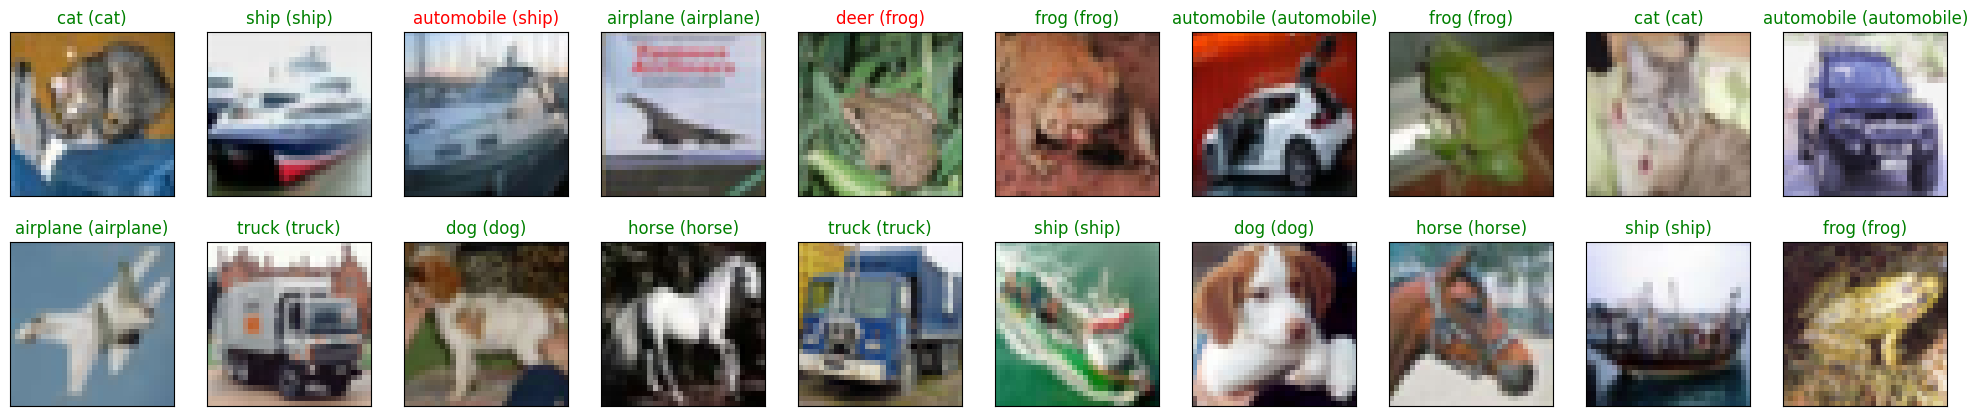

In [ ]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 5))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))